In [27]:
import numpy as np
import pandas as pd
from functions import utils
from functions import functions as utils2,classification_utils
from functions import scoring
import plotly.express as px
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from lightgbm import LGBMClassifier
import seaborn as sns
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_colwidth', None)

In [ ]:
doc=utils2.reduce_memory_usage(pd.read_csv(path+'HomeCredit_columns_description.csv',encoding='unicode_escape'))
def find_doc(cols):
    return(doc[doc['Row'].isin(cols)][['Row','Description']])

## Partie 1: Etude dataframe application_train et application_test

application_{train|test}.csv
* Il s'agit de la table principale, divisée en deux fichiers pour Train (avec TARGET) et Test (sans TARGET).
* Données statiques pour toutes les applications. Une ligne représente un prêt dans notre échantillon de données.

In [28]:
path='data/'
df_train =  utils2.reduce_memory_usage(pd.read_csv(path+'application_train.csv'))
df_test =utils2.reduce_memory_usage( pd.read_csv(path+'application_test.csv'))
df_train=df_train.append(df_test)


Memory usage of dataframe is 286.23 MB
Memory usage after optimization is: 92.38 MB
Decreased by 67.7%
Memory usage of dataframe is 45.00 MB
Memory usage after optimization is: 14.60 MB
Decreased by 67.6%


In [30]:
df_train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1.0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0.0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0.0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0.0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0.0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,456221,NaN,Cash loans,F,N,Y,0,121500.0,412560.0,17473.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
48740,456222,NaN,Cash loans,F,N,N,2,157500.0,622413.0,31909.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
48741,456223,NaN,Cash loans,F,Y,Y,1,202500.0,315000.0,33205.5,...,0,0,0,0,0.0,0.0,0.0,0.0,3.0,1.0
48742,456224,NaN,Cash loans,M,N,N,0,225000.0,450000.0,25128.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0


In [32]:
def correlation_with_target_top_n(df,target,n):
    '''
    Calculate the correltation
    '''
    df_corr= df.corr()[target].sort_values()
    #print(n,'Positive Correlations:\n', df_corr.tail(n))
    #print('\n',n,' Negative Correlations:\n', df_corr.head(n))
    return df_corr

In [33]:
def density_with_target(app_train,target,feature,title=''):
    #ax=plt.subplots(2,2,figsize=(15,15))
    #ax.title.set_text(feature)
    plt.xlabel(feature)
    plt.ylabel('Density')
    sns.kdeplot(app_train.loc[app_train[target] == 0, feature] , label ='Paid=Yes')
    sns.kdeplot(app_train.loc[app_train[target] == 1, feature] , label ='Paid=No')
    plt.legend()
    plt.title(title)

In [34]:
def one_hot_encoding_dataframe(df):
    '''
    one hot encoding 
    '''
    original_columns = list(df.columns)
    cat_columns=[x for x in df.columns if df[x].dtype == 'object']
    df=pd.get_dummies(df,columns=cat_columns,dummy_na= False)
    new_added_columns=list(set(df.columns).difference(set(original_columns)))
    return df,new_added_columns,df.columns

In [35]:
df_train=df_train.append(df_test)

In [36]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356255 entries, 0 to 48743
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float16(61), float32(4), float64(1), int16(2), int32(2), int8(36), object(16)
memory usage: 112.1+ MB


In [37]:
df_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1.0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0.0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0.0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0.0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0.0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


* Aucun doublon de clients  selon l'identifiant unique SK_ID_CURR

In [38]:

len(df_train.loc[df_train.duplicated(subset='SK_ID_CURR',keep='first')]) ## 0 aucun doublons

0

* conversion en euros des montants exprimés en rouppie indienne

In [39]:
currency=86   
df_train['AMT_GOODS_PRICE']=df_train['AMT_GOODS_PRICE']/currency
df_train['AMT_CREDIT']=df_train['AMT_CREDIT']/currency
df_train['AMT_ANNUITY']=df_train['AMT_ANNUITY']/currency
df_train['AMT_INCOME_TOTAL']=df_train['AMT_INCOME_TOTAL']/currency

df_train['AMT_INCOME_TOTAL']=df_train['AMT_INCOME_TOTAL'].apply(np.ceil)
df_train['AMT_CREDIT']=df_train['AMT_CREDIT'].apply(np.ceil)
df_train['AMT_ANNUITY']=df_train['AMT_ANNUITY'].apply(np.ceil)

* conversion en année de l'age, l'expérience professionnelle, l'ancienneté à la banque

In [40]:
df_train['AGE']=df_train['DAYS_BIRTH']/(-365)
df_train['AGE']=df_train['AGE'].apply(np.ceil) 
 


df_train['PRO_SENIORITY']=df_train['DAYS_EMPLOYED']/(-365)
df_train['PRO_SENIORITY']=df_train['PRO_SENIORITY'].apply(np.ceil) 

 


df_train['ACCOUNT_SENIORITY']=df_train['DAYS_REGISTRATION']/(-365)
df_train['ACCOUNT_SENIORITY']=df_train['ACCOUNT_SENIORITY'].apply(np.ceil) 

 
 

cols_to_remove=['DAYS_BIRTH','DAYS_EMPLOYED','DAYS_REGISTRATION']

if set(cols_to_remove).issubset(df_train.columns.tolist()):
    df_train.drop(columns=cols_to_remove,axis=1,inplace=True)


In [41]:
df_train[['AGE','ACCOUNT_SENIORITY','PRO_SENIORITY']].describe()

,AGE,ACCOUNT_SENIORITY,PRO_SENIORITY
count,356255.000000,356255.000000,356255.000000
mean,44.445487,14.158047,-175.679659
std,11.940836,9.659963,388.171433
min,21.000000,-0.000000,-1000.000000
25%,35.000000,6.000000,1.000000
50%,44.000000,13.000000,4.000000
75%,54.000000,21.000000,8.000000
max,70.000000,68.000000,50.000000


* 64648 observations enregistrent une ancienneté à la banque non seulement négatives, mais de 1000 ans, ce qui est aberrant
* les supprimmer entraine une perte d'information, autant les imputer

In [42]:
count_negative=df_train[df_train['PRO_SENIORITY']<0][['PRO_SENIORITY']]

print('len(count_negative)',len(count_negative))
print('unique values',count_negative.PRO_SENIORITY.unique())
def age_(x):
    if x<0 or x==-0:
        return np.nan
    return x
df_train['PRO_SENIORITY'] = df_train['PRO_SENIORITY'].map(age_)
df_train['ACCOUNT_SENIORITY'] = df_train['ACCOUNT_SENIORITY'].map(age_)
df_train[['AGE','ACCOUNT_SENIORITY','PRO_SENIORITY']].describe()

len(count_negative) 64648
unique values [-1000.]


,AGE,ACCOUNT_SENIORITY,PRO_SENIORITY
count,356255.000000,356162.000000,291605.000000
mean,44.445487,14.161744,7.068613
std,11.940836,9.657489,6.403140
min,21.000000,1.000000,1.000000
25%,35.000000,6.000000,3.000000
50%,44.000000,13.000000,5.000000
75%,54.000000,21.000000,9.000000
max,70.000000,68.000000,50.000000


### 1 <u>Analyse de la variable cible</u>

In [43]:
df_train['TARGET'].value_counts()

0.0    282686
1.0     24825
Name: TARGET, dtype: int64

<AxesSubplot:ylabel='TARGET'>

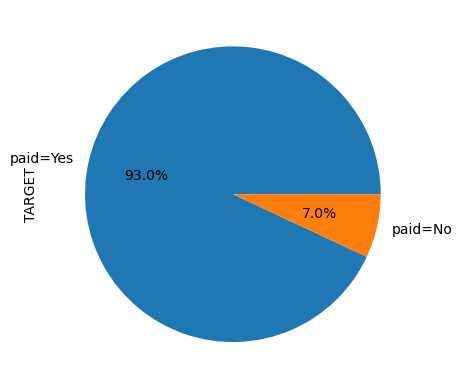

In [44]:

df_train['TARGET'].map(lambda x: 'paid=No' if x==1 else 'paid=Yes')\
    .value_counts()\
    .plot\
    .pie(autopct='%1.1f%%')

on note un déséquilibre de classe:
* 8.1% des clients sont en défaut de paiement (24825)
* 91.9% des clients ne sont pas en défaut de paiement (282686)

In [45]:
len(df_train[df_train['AMT_INCOME_TOTAL']<10000])

355715

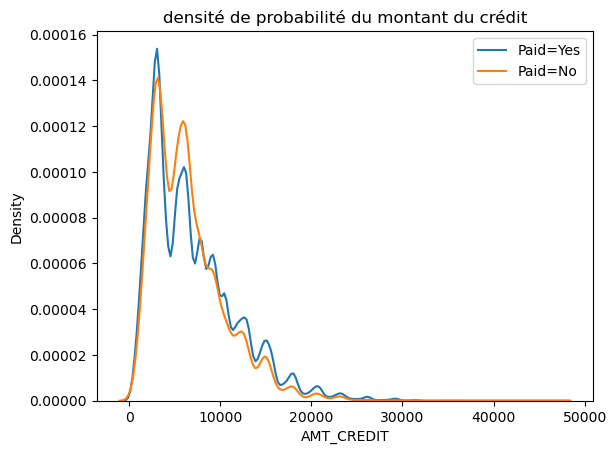

In [46]:
density_with_target(df_train,'TARGET','AMT_CREDIT',title='densité de probabilité du montant du crédit')

### 2 <u>Analyse des valeurs manquantes et suppression de variables</u>

In [47]:
na_df=utils.columns_na_percentage(df_train)
na_columns=na_df[na_df['na_rate_percent']>40] ## 49 colonnes ont  des valeurs nulles
na_columns

,Column,na_rate_percent
0,COMMONAREA_AVG,69.714109
1,COMMONAREA_MEDI,69.714109
2,COMMONAREA_MODE,69.714109
3,NONLIVINGAPARTMENTS_AVG,69.293343
4,NONLIVINGAPARTMENTS_MODE,69.293343
5,NONLIVINGAPARTMENTS_MEDI,69.293343
6,FONDKAPREMONT_MODE,68.235393
7,LIVINGAPARTMENTS_MEDI,68.203674
8,LIVINGAPARTMENTS_AVG,68.203674
9,LIVINGAPARTMENTS_MODE,68.203674


* suppression des variables ayant plus de 45% de valeurs manquantes

In [48]:
cols_to_remove=na_columns.Column.tolist()
 
    
if set(cols_to_remove).issubset(df_train.columns.tolist()):
    df_train.drop(columns=cols_to_remove,axis=1,inplace=True)

* suppression des variables relatives au nombre de renseignements faits par l'emprunteur avant de demander le prêt,téléphone,mail etc ...

In [49]:

cols_to_remove=['AMT_REQ_CREDIT_BUREAU_HOUR','AMT_REQ_CREDIT_BUREAU_DAY',
                'AMT_REQ_CREDIT_BUREAU_QRT','AMT_REQ_CREDIT_BUREAU_YEAR',
                'AMT_REQ_CREDIT_BUREAU_WEEK','AMT_REQ_CREDIT_BUREAU_MON',
               'FLAG_MOBIL','FLAG_EMP_PHONE','FLAG_CONT_MOBILE','FLAG_PHONE',
                'FLAG_EMAIL','HOUR_APPR_PROCESS_START','DAYS_LAST_PHONE_CHANGE',
                'WEEKDAY_APPR_PROCESS_START',
                'OBS_30_CNT_SOCIAL_CIRCLE',
                 'DEF_30_CNT_SOCIAL_CIRCLE',
                 'OBS_60_CNT_SOCIAL_CIRCLE',
                 'DEF_60_CNT_SOCIAL_CIRCLE',
                'FLAG_WORK_PHONE',
                
                'DAYS_ID_PUBLISH',
                 'REG_REGION_NOT_LIVE_REGION',
                 'REG_REGION_NOT_WORK_REGION',
                 'LIVE_REGION_NOT_WORK_REGION',
                 'REG_CITY_NOT_LIVE_CITY',
                 'REG_CITY_NOT_WORK_CITY',
                 'LIVE_CITY_NOT_WORK_CITY',
               ]
 
    
if set(cols_to_remove).issubset(df_train.columns.tolist()):
    df_train.drop(columns=cols_to_remove,axis=1,inplace=True)

In [50]:
find_doc(['WEEKDAY_APPR_PROCESS_START'])

,Row,Description
32,WEEKDAY_APPR_PROCESS_START,On which day of the week did the client apply for the loan
181,WEEKDAY_APPR_PROCESS_START,On which day of the week did the client apply for previous application


In [51]:
df_train.isnull().sum()/len(df_train)*100

SK_ID_CURR                      0.000000
TARGET                         13.682334
NAME_CONTRACT_TYPE              0.000000
CODE_GENDER                     0.000000
FLAG_OWN_CAR                    0.000000
FLAG_OWN_REALTY                 0.000000
CNT_CHILDREN                    0.000000
AMT_INCOME_TOTAL                0.000000
AMT_CREDIT                      0.000000
AMT_ANNUITY                     0.010105
AMT_GOODS_PRICE                 0.078034
NAME_TYPE_SUITE                 0.618377
NAME_INCOME_TYPE                0.000000
NAME_EDUCATION_TYPE             0.000000
NAME_FAMILY_STATUS              0.000000
NAME_HOUSING_TYPE               0.000000
REGION_POPULATION_RELATIVE      0.000000
OCCUPATION_TYPE                31.437032
CNT_FAM_MEMBERS                 0.000561
REGION_RATING_CLIENT            0.000000
REGION_RATING_CLIENT_W_CITY     0.000000
ORGANIZATION_TYPE               0.000000
EXT_SOURCE_2                    0.187506
EXT_SOURCE_3                   19.545831
FLAG_DOCUMENT_2 

In [52]:
cols = [x for x in df_train.columns.tolist() if x not in ['TARGET','SK_ID_CURR']]
numeric_cols=df_train[cols].select_dtypes(exclude = ['object']).columns.tolist()
string_cols=df_train[cols].select_dtypes(include = ['object']).columns.tolist()
print('len(numeric_cols)',len(numeric_cols))
print('len(string_cols)',len(string_cols))

len(numeric_cols) 34
len(string_cols) 11


In [53]:
numeric_cols

['CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_16',
 'FLAG_DOCUMENT_17',
 'FLAG_DOCUMENT_18',
 'FLAG_DOCUMENT_19',
 'FLAG_DOCUMENT_20',
 'FLAG_DOCUMENT_21',
 'AGE',
 'PRO_SENIORITY',
 'ACCOUNT_SENIORITY']

In [54]:
na_df=utils.columns_na_percentage(df_train)
na_columns=na_df[na_df['na_rate_percent']>0] ## 6 colonnes ont  des valeurs nulles

na_columns

,Column,na_rate_percent
0,OCCUPATION_TYPE,31.437032
1,EXT_SOURCE_3,19.545831
2,PRO_SENIORITY,18.147114
3,TARGET,13.682334
4,NAME_TYPE_SUITE,0.618377
5,EXT_SOURCE_2,0.187506
6,AMT_GOODS_PRICE,0.078034
7,ACCOUNT_SENIORITY,0.026105
8,AMT_ANNUITY,0.010105
9,CNT_FAM_MEMBERS,0.000561


In [55]:
"""
correlation_with_target_top_n(df_train,'TARGET',100
                             )
"""

"\ncorrelation_with_target_top_n(df_train,'TARGET',100\n                             )\n"

### 3 <u>Analyse des variables qualitatives</u>

In [56]:
for col in string_cols:
    print(col,df_train[col].nunique())

NAME_CONTRACT_TYPE 2
CODE_GENDER 3
FLAG_OWN_CAR 2
FLAG_OWN_REALTY 2
NAME_TYPE_SUITE 7
NAME_INCOME_TYPE 8
NAME_EDUCATION_TYPE 5
NAME_FAMILY_STATUS 6
NAME_HOUSING_TYPE 6
OCCUPATION_TYPE 18
ORGANIZATION_TYPE 58


* suppression la variable ORGANIZATION_TYPE car elle possède 58 valeurs uniques, son encodage pourrait altérer la qualité de la classification

In [57]:
cols_to_remove=['ORGANIZATION_TYPE']
if set(cols_to_remove).issubset(df_train.columns.tolist()):
    df_train.drop(columns=cols_to_remove,axis=1,inplace=True)
    
if set(cols_to_remove).issubset(string_cols):
    string_cols.remove(cols_to_remove[0])

* imputation des valeurs nulle par unknown

In [58]:
for col in string_cols:
    df_train[col]=df_train[col].fillna('unknown')

### 4 <u>Analyse des variables quantitatives</u>

In [59]:



na_df=utils.columns_na_percentage(df_train[numeric_cols])
na_columns=na_df[na_df['na_rate_percent']>0] ## 6 colonnes ont  des valeurs nulles
na_columns

,Column,na_rate_percent
0,EXT_SOURCE_3,19.545831
1,PRO_SENIORITY,18.147114
2,EXT_SOURCE_2,0.187506
3,AMT_GOODS_PRICE,0.078034
4,ACCOUNT_SENIORITY,0.026105
5,AMT_ANNUITY,0.010105
6,CNT_FAM_MEMBERS,0.000561


* il y a 36 clients pour qui on ignore le montant de l'annuité, il serait mieux de les ignorer

In [60]:
na_annuity=df_train[
   ( pd.isna(df_train['AMT_ANNUITY']))
]
print(len(na_annuity))

36


* suppression des 36 observations

In [61]:

df_train.drop(na_annuity.index, axis=0, inplace=True)

* 2 les valeurs nulles pour le nombre de personnes composant le foyer familial, le nombre d'enfant est égal à 0, on impute par 1 les valeurs nulles 

In [62]:
df_train[pd.isna(df_train['CNT_FAM_MEMBERS'])][['CNT_FAM_MEMBERS','CNT_CHILDREN']]

,CNT_FAM_MEMBERS,CNT_CHILDREN
41982,NaN,0
187348,NaN,0


In [63]:
df_train['CNT_FAM_MEMBERS']=df_train['CNT_FAM_MEMBERS'].fillna(0)

In [64]:
na_df=utils.columns_na_percentage(df_train[numeric_cols])
na_columns=na_df[na_df['na_rate_percent']>0] 
na_columns

,Column,na_rate_percent
0,EXT_SOURCE_3,19.546371
1,PRO_SENIORITY,18.147695
2,EXT_SOURCE_2,0.187538
3,AMT_GOODS_PRICE,0.078047
4,ACCOUNT_SENIORITY,0.026109


* imputation des autres variables par leurs valeurs medianes

In [65]:
for col in na_columns['Column'].tolist():
    df_train[col]=df_train[col].fillna(df_train[col].median())

In [66]:
na_df=utils.columns_na_percentage(df_train)
na_columns=na_df[na_df['na_rate_percent']>0] 
na_columns

,Column,na_rate_percent
0,TARGET,13.677659


### 5 <u>Feature engeneering</u>

In [67]:
# * pourcentage de l'annuité par rapport au crédit: rapport entre le montant de l'annuité et celui du crédit dû
df_train['ANNUITY_AMT_CREDIT_PERCENT'] =(
    df_train['AMT_ANNUITY'] /( df_train['AMT_CREDIT'])
)*100
df_train['ANNUITY_AMT_CREDIT_PERCENT']=df_train['ANNUITY_AMT_CREDIT_PERCENT'].apply(np.ceil) 
if 'ANNUITY_AMT_CREDIT_PERCENT' not in numeric_cols:
    numeric_cols.append('ANNUITY_AMT_CREDIT_PERCENT')
    
# * rapport entre le montant de l'annuité et le revenu annuel du client
df_train['ANNUITY_INCOME_PERCENT'] = (
     df_train['AMT_ANNUITY'] /df_train['AMT_INCOME_TOTAL']
    )*100
df_train['ANNUITY_INCOME_PERCENT']=df_train['ANNUITY_INCOME_PERCENT'].apply(np.ceil)
if 'ANNUITY_INCOME_PERCENT' not in numeric_cols:
    numeric_cols.append('ANNUITY_INCOME_PERCENT')
    
  
# * la durée du prêt: rapport entre le montant du crédit et l'annuité

df_train['CREDIT_TERM'] =(
 df_train['AMT_CREDIT'] / df_train['AMT_ANNUITY']
)
df_train['CREDIT_TERM']=df_train['CREDIT_TERM'].apply(np.ceil) 
# * l'âge de l'emprunteur lorsque le crédit arriverait à terme
df_train['AGE_LOAN_FINISH'] = df_train['AGE'] + df_train['CREDIT_TERM']
df_train['AGE_LOAN_FINISH']=df_train['AGE_LOAN_FINISH'].apply(np.ceil) 


# * pourcentage du prêt alloué à l'achat de biens et ou services
df_train['GOODS_LOAN_PERCENT'] =(
 df_train['AMT_GOODS_PRICE'] / df_train['AMT_CREDIT']
)*100

df_train['GOODS_LOAN_PERCENT']=df_train['GOODS_LOAN_PERCENT'].apply(np.ceil) 

# * revenu net du client après paiement de l'annuité: différence entre le revenu annuel et le montant de l'annuité
df_train['INCOME_AFTER_ANNUITY'] =(
 df_train['AMT_INCOME_TOTAL'] - df_train['AMT_ANNUITY']
)
df_train['INCOME_AFTER_ANNUITY']=df_train['INCOME_AFTER_ANNUITY'].apply(np.ceil) 

# * revenu net par tête du foyer familial après paiement de l'annuité: 
  # rapport le nombre de personnes composant la famille entre le revenu net
    
df_train['NET_INCOME_PER_FAMILY_HEAD_AFTER_ANNUITY'] =(
 df_train['INCOME_AFTER_ANNUITY']/df_train['CNT_FAM_MEMBERS']
)
df_train['NET_INCOME_PER_FAMILY_HEAD_AFTER_ANNUITY']=df_train['NET_INCOME_PER_FAMILY_HEAD_AFTER_ANNUITY'].apply(np.ceil) 
#NET_INCOME_PER_FAMILY_HEAD_AFTER_ANNUITY    NET_INCOME_PER_FAMILY_HEAD_AFTER_ANNUITY
# nombre de documents fournis
regex='FLAG_DOCUMENT'
DOCUMENT_COLS=[x for x in 
           df_train.columns[df_train\
                                 .columns.str.contains(regex)]
          ]
DOCUMENT_COLS
df_train['DOCUMENT_COUNT']=(df_train[DOCUMENT_COLS]==1).sum(axis=1)
if set(DOCUMENT_COLS).issubset(df_train.columns.tolist()):
    df_train.drop(columns=DOCUMENT_COLS,axis=1,inplace=True)

    
# rapport entr
df_train['DAYS_WORKING_PERCENT']=df_train['PRO_SENIORITY'] / df_train['AGE']
    
df_train['DAYS_UNEMPLOYED']=abs(df_train['AGE'])-abs(df_train['PRO_SENIORITY'])

df_train['EXT_SOURCE_MEAN']=(df_train[[ 'EXT_SOURCE_2',
       'EXT_SOURCE_3']]).mean(axis=1)
    
df_train['EXT_SOURCE_MEDIAN']=(df_train[[ 'EXT_SOURCE_2',
       'EXT_SOURCE_3']]).median(axis=1)
    
df_train['EXT_SOURCE_MIN']=(df_train[[ 'EXT_SOURCE_2',
       'EXT_SOURCE_3']]).min(axis=1)
    
df_train['EXT_SOURCE_MAX']=(df_train[[ 'EXT_SOURCE_2',
       'EXT_SOURCE_3']]).max(axis=1)
for col in DOCUMENT_COLS:
    if col in numeric_cols:
        numeric_cols.remove(col)
for col in ['EXT_SOURCE_MEAN','EXT_SOURCE_MEDIAN','EXT_SOURCE_MIN','EXT_SOURCE_MAX']:
    if col not in numeric_cols:
        numeric_cols.append(col)
        
#find max value of column
max_value = np.nanmax(df_train['NET_INCOME_PER_FAMILY_HEAD_AFTER_ANNUITY'][df_train['NET_INCOME_PER_FAMILY_HEAD_AFTER_ANNUITY'] != np.inf])

#replace inf and -inf in column with max value of column 
df_train['NET_INCOME_PER_FAMILY_HEAD_AFTER_ANNUITY'].replace([np.inf, -np.inf], max_value, inplace=True)

In [68]:
df_train.sort_values(ascending=False,by='NET_INCOME_PER_FAMILY_HEAD_AFTER_ANNUITY')[['NET_INCOME_PER_FAMILY_HEAD_AFTER_ANNUITY']]

,NET_INCOME_PER_FAMILY_HEAD_AFTER_ANNUITY
187348,453387.0
41982,453387.0
12840,453387.0
246858,77727.0
203693,52125.0
...,...
43774,-107.0
678,-117.0
20727,-130.0
197677,-149.0


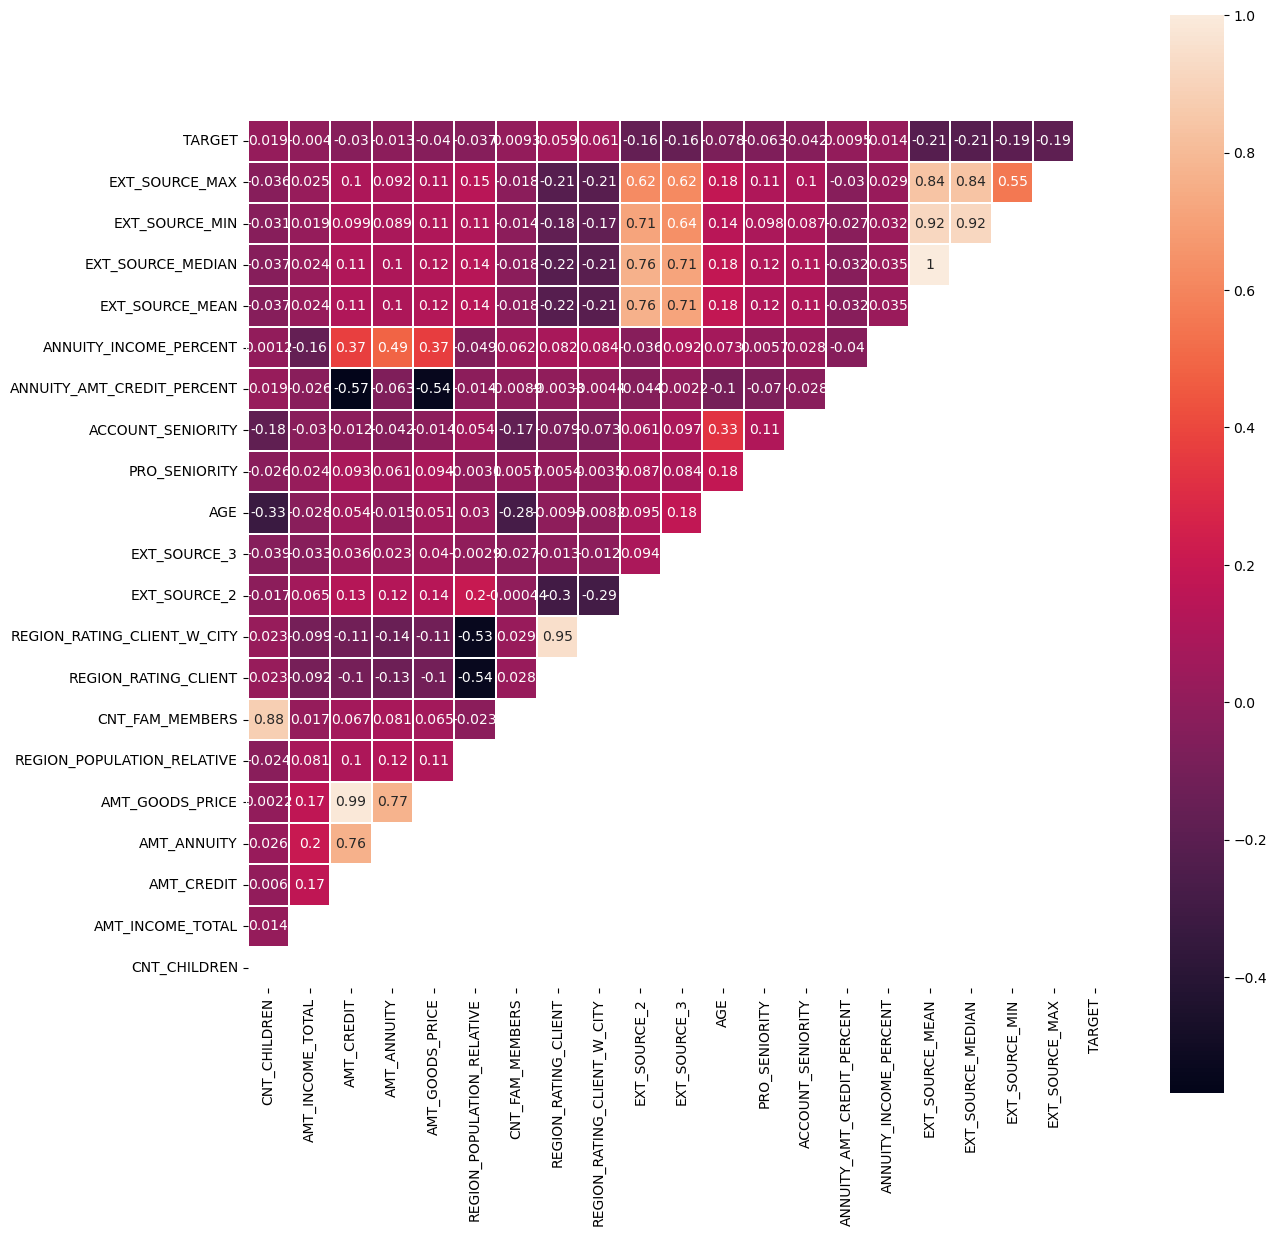

In [69]:
#cols=[item for item in relevant_numeric_columns if item!='YearBuilt' and item not in target_cols and item not in ['lat','lng']]
utils.show_correlation_matrix(df_train,numeric_cols+['TARGET'])

* les variables nombre d'enfants (CNT_CHILDREN) et le nombre de personnes du foyer familial(CNT_FAM_MEMBERS) ont une corrélation presque absolue 0.99. omission de la variable CNT_FAM_MEMBERS
* les variables 'EXT_SOURCE_MEAN','EXT_SOURCE_MIN','EXT_SOURCE_MAX' sont trop corrélées entre elles, on garde que la moyenne
* le montant du crédit AMT_CREDIT et le montant alloué à l'achat de biens AMT_GOODS_PRICE trop corrélés



In [70]:
cols_to_remove=['CNT_FAM_MEMBERS','EXT_SOURCE_2','EXT_SOURCE_3','EXT_SOURCE_MEDIAN','EXT_SOURCE_MIN','EXT_SOURCE_MAX','AMT_GOODS_PRICE','REGION_RATING_CLIENT']
for col in cols_to_remove:
    if col  in numeric_cols:
        numeric_cols.remove(col)
if set(cols_to_remove).issubset(df_train.columns.tolist()):
    df_train.drop(columns=cols_to_remove,axis=1,inplace=True)

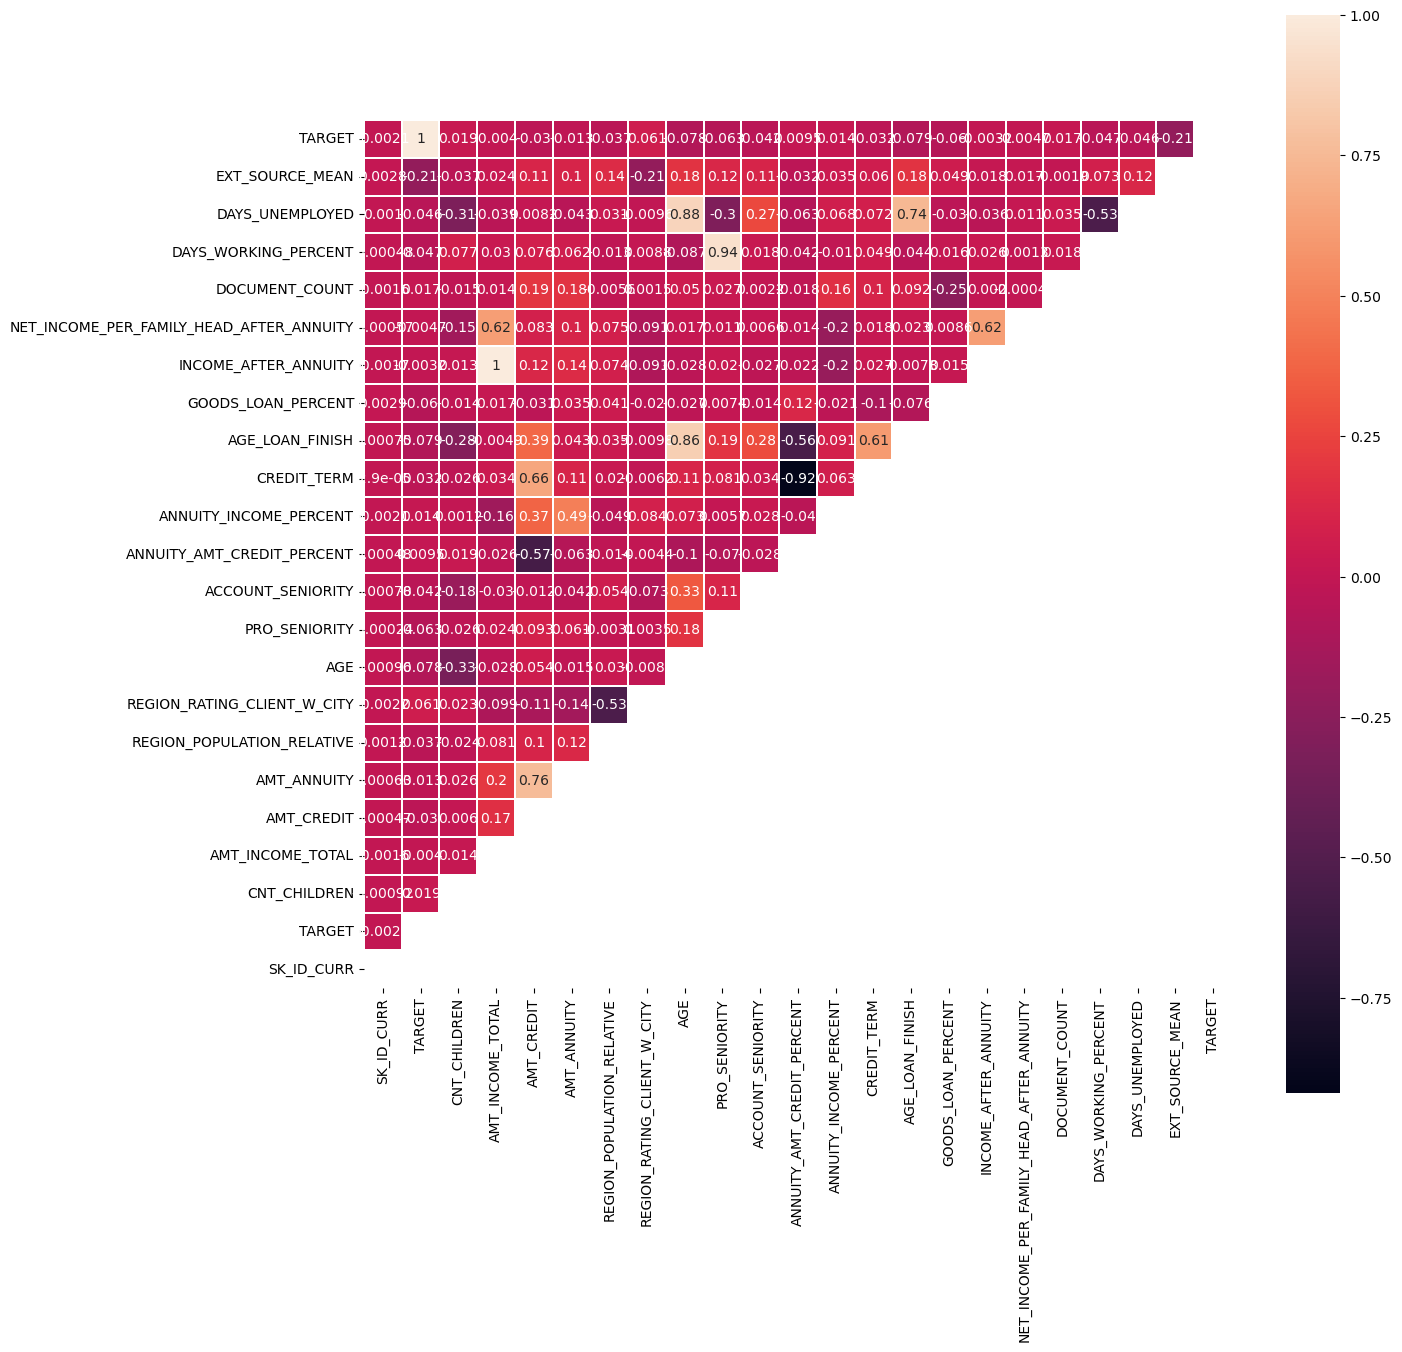

In [71]:
cols=df_train.select_dtypes(exclude = ['object']).columns.tolist()
utils.show_correlation_matrix(df_train,cols+['TARGET'])
#correlation_with_target_top_n(df_train,'TARGET',len(df_train.columns.tolist())).reset_index()

In [72]:
df_train.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'REGION_POPULATION_RELATIVE', 'OCCUPATION_TYPE',
       'REGION_RATING_CLIENT_W_CITY', 'AGE', 'PRO_SENIORITY',
       'ACCOUNT_SENIORITY', 'ANNUITY_AMT_CREDIT_PERCENT',
       'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'AGE_LOAN_FINISH',
       'GOODS_LOAN_PERCENT', 'INCOME_AFTER_ANNUITY',
       'NET_INCOME_PER_FAMILY_HEAD_AFTER_ANNUITY', 'DOCUMENT_COUNT',
       'DAYS_WORKING_PERCENT', 'DAYS_UNEMPLOYED', 'EXT_SOURCE_MEAN'],
      dtype='object')

In [73]:
df_f,new_added_columns,columns = one_hot_encoding_dataframe(df_train)

In [74]:
df_f.shape

(356194, 83)

### 6 <u>Essai de classification</u>

In [75]:
df=df_f[~pd.isna(df_f['TARGET'])]
cols=[col for col in df.columns.tolist() if col not in ['index','SK_ID_CURR','TARGET']]
X=df[cols]
y=df['TARGET']
 
    
# Application du SMOTE aux données
X_res, y_res =scoring.smotify(X,y,k_neighbors=3,sampling_strategy=0.50)

In [76]:
from sklearn.preprocessing import  StandardScaler
X=StandardScaler().fit_transform(X_res)


ARI 0.7672


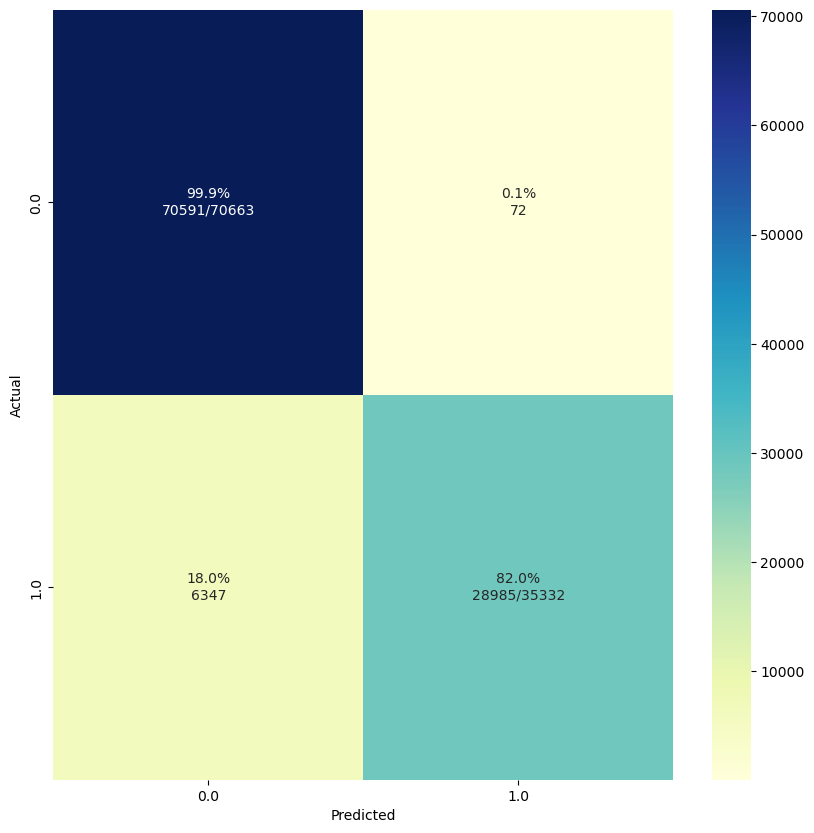

In [77]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
random_state=42
X_train,X_test,y_train,y_test=train_test_split(X,y_res,stratify=y_res)
scoring='f1_macro'
 
cv=5
"""
param_grid = { 
    #'n_estimators': [200, 500],
    #'max_features': ['auto', 'sqrt', 'log2'],
    #'max_depth' : [4,5,6,7,8],
    'criterion' :['gini']
}

"""       
param_grid={
     'objective' : ['binary'],
}
 
model=LGBMClassifier()
ARI,gr=classification_utils.grid_search_cv_binaryclass(model,param_grid,scoring,cv,X_train,X_test,y_train,y_test)

In [78]:
"""
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler
train_data_df=df[df['TARGET'].notnull()]
train_column=set(train_data_df.columns)-set({'TARGET','index','SK_ID_CURR'})

y_train=train_data_df['TARGET']
X_train=train_data_df[train_column]
#print(X_train)
train_column=X_train.columns

 

scaler = MinMaxScaler(feature_range = (0, 1))
#scaler.fit(X_train)
X_train = scaler.fit_transform(X_train.values)

lgbm_clf = LGBMClassifier(nthread = -1,random_state=42)
lgbm_clf.fit(X_train,y_train)

print("ROCAUC Score :",roc_auc_score(y_train,lgbm_clf.predict_proba(X_train)[:,1]))
"""

'\nfrom sklearn.metrics import roc_auc_score\nfrom sklearn.preprocessing import MinMaxScaler\ntrain_data_df=df[df[\'TARGET\'].notnull()]\ntrain_column=set(train_data_df.columns)-set({\'TARGET\',\'index\',\'SK_ID_CURR\'})\n\ny_train=train_data_df[\'TARGET\']\nX_train=train_data_df[train_column]\n#print(X_train)\ntrain_column=X_train.columns\n\n \n\nscaler = MinMaxScaler(feature_range = (0, 1))\n#scaler.fit(X_train)\nX_train = scaler.fit_transform(X_train.values)\n\nlgbm_clf = LGBMClassifier(nthread = -1,random_state=42)\nlgbm_clf.fit(X_train,y_train)\n\nprint("ROCAUC Score :",roc_auc_score(y_train,lgbm_clf.predict_proba(X_train)[:,1]))\n'

## Partie 2: Etude dataframe bureau et bureau_balance
    

In [84]:
def clean_columns(df,threshold=30):
    na_df=utils.columns_na_percentage(df)
    na_columns=na_df[na_df['na_rate_percent']>=threshold]
    df.drop(columns=na_columns['Column'].tolist(),axis=1,inplace=True)
    return df

In [85]:
df_bureau =utils2.reduce_memory_usage( pd.read_csv(path+'bureau.csv'))
#df_bureau_balance = utils2.reduce_memory_usage(pd.read_csv(path+'bureau_balance.csv'))
df_bureau=clean_columns(df_bureau,threshold=30)

Memory usage of dataframe is 222.62 MB
Memory usage after optimization is: 112.95 MB
Decreased by 49.3%


In [81]:
df_bureau.isnull().sum()/len(df_bureau)*100

SK_ID_CURR                 0.000000
SK_ID_BUREAU               0.000000
CREDIT_ACTIVE              0.000000
CREDIT_CURRENCY            0.000000
DAYS_CREDIT                0.000000
CREDIT_DAY_OVERDUE         0.000000
DAYS_CREDIT_ENDDATE        6.149573
DAYS_ENDDATE_FACT         36.916958
AMT_CREDIT_MAX_OVERDUE    65.513264
CNT_CREDIT_PROLONG         0.000000
AMT_CREDIT_SUM             0.000757
AMT_CREDIT_SUM_DEBT       15.011932
AMT_CREDIT_SUM_LIMIT      34.477415
AMT_CREDIT_SUM_OVERDUE     0.000000
CREDIT_TYPE                0.000000
DAYS_CREDIT_UPDATE         0.000000
AMT_ANNUITY               71.473490
dtype: float64

In [86]:
df_bureau.isnull().sum()/len(df_bureau)*100

SK_ID_CURR                 0.000000
SK_ID_BUREAU               0.000000
CREDIT_ACTIVE              0.000000
CREDIT_CURRENCY            0.000000
DAYS_CREDIT                0.000000
CREDIT_DAY_OVERDUE         0.000000
DAYS_CREDIT_ENDDATE        6.149573
CNT_CREDIT_PROLONG         0.000000
AMT_CREDIT_SUM             0.000757
AMT_CREDIT_SUM_DEBT       15.011932
AMT_CREDIT_SUM_OVERDUE     0.000000
CREDIT_TYPE                0.000000
DAYS_CREDIT_UPDATE         0.000000
dtype: float64

In [104]:
nb_past_loans = df_bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count().rename(
    columns = {'SK_ID_BUREAU': 'COUNT_PAST_LOANS'}
)
nb_past_loans

,SK_ID_CURR,COUNT_PAST_LOANS
0,100001,7
1,100002,8
2,100003,4
3,100004,2
4,100005,3
...,...,...
305806,456249,13
305807,456250,3
305808,456253,4
305809,456254,1


In [88]:
numeric_cols=df_bureau.select_dtypes(exclude = ['object']).columns.tolist()
string_cols=df_bureau.select_dtypes(include = ['object']).columns.tolist()
print('len(numeric_cols)',len(numeric_cols))
print('len(string_cols)',len(string_cols))

len(numeric_cols) 10
len(string_cols) 3


In [101]:

cols_to_remove=['CREDIT_CURRENCY']
 
if set(cols_to_remove).issubset(string_cols):
    string_cols.remove(cols_to_remove[0]) 
    
if set(cols_to_remove).issubset(df_bureau.columns.tolist()):
    df_bureau.drop(columns=cols_to_remove,axis=1,inplace=True) 

In [92]:
for col in string_cols:
    df_bureau[col]=df_bureau[col].fillna('unknown')

for col in numeric_cols:
    if col not in ['SK_ID_CURR','SK_ID_BUREAU','index']:
        df_bureau[col]=df_bureau[col].fillna(df_bureau[col].median())
        

In [97]:
def numeric_vars_agg(df_var,groupby_var,agg,suffix,cols_to_remove):
    df_agg=df_var
    if set(cols_to_remove).issubset(df_var.columns.tolist()):
        df_agg=df_var.drop(columns=cols_to_remove)
        
    df_agg=df_agg.groupby(groupby_var,as_index=False)\
        .agg(agg).reset_index()


    # List of column names
    columns = [groupby_var]

    # Iterate through the variables names
    for var in df_agg.columns.levels[0]:
        # Skip the id name
        if var != groupby_var:

            # Iterate through the stat names
            for stat in df_agg.columns.levels[1][:-1]:
                # Make a new column name for the variable and stat
                columns.append('%s_%s_%s' % (suffix,var, stat))


    # Assign the list of columns names as the dataframe column names
    df_agg.columns = columns
    #df_train_test=df_train_test.merge(df_agg,on=groupby_var,how='left')
    return df_agg
    #df_bureau_agg.head()
    
def most_frequent_str_var(df_var,str_cols,groupby_var,suffix):
    related_cols = str_cols+[groupby_var]
    agg=dict()
    agg_rename_cols=dict()
    for col in str_cols:
        agg[col]=(lambda x: pd.Series.mode(x)[0])
        agg_rename_cols[col]="frequent-{}-{}".format(suffix, col)
    
    df_agg=df_var[related_cols].groupby(groupby_var)\
        .agg(agg).reset_index().rename(columns=agg_rename_cols)
    
    return df_agg

In [102]:
df_bureau_agg_numeric=numeric_vars_agg(
    df_bureau,'SK_ID_CURR',['mean','min','max','std','sum'],'BUREAU',['SK_ID_BUREAU']
)
df_bureau_agg_numeric.head()

,SK_ID_CURR,BUREAU_DAYS_CREDIT_mean,BUREAU_DAYS_CREDIT_min,BUREAU_DAYS_CREDIT_max,BUREAU_DAYS_CREDIT_std,BUREAU_CREDIT_DAY_OVERDUE_mean,BUREAU_CREDIT_DAY_OVERDUE_min,BUREAU_CREDIT_DAY_OVERDUE_max,BUREAU_CREDIT_DAY_OVERDUE_std,BUREAU_DAYS_CREDIT_ENDDATE_mean,...,BUREAU_AMT_CREDIT_SUM_DEBT_max,BUREAU_AMT_CREDIT_SUM_DEBT_std,BUREAU_AMT_CREDIT_SUM_OVERDUE_mean,BUREAU_AMT_CREDIT_SUM_OVERDUE_min,BUREAU_AMT_CREDIT_SUM_OVERDUE_max,BUREAU_AMT_CREDIT_SUM_OVERDUE_std,BUREAU_DAYS_CREDIT_UPDATE_mean,BUREAU_DAYS_CREDIT_UPDATE_min,BUREAU_DAYS_CREDIT_UPDATE_max,BUREAU_DAYS_CREDIT_UPDATE_std
0,100001,-735.000000,-1572,-49,489.942514,0.0,0,0,0.0,82.4375,...,373239.0,137485.631124,0.0,0.0,0.0,0.0,-93.142857,-155,-6,77.204120
1,100002,-874.000000,-1437,-103,431.451040,0.0,0,0,0.0,-344.2500,...,245781.0,86896.705893,0.0,0.0,0.0,0.0,-499.875000,-1185,-7,518.522472
2,100003,-1400.750000,-2586,-606,909.826128,0.0,0,0,0.0,-544.5000,...,0.0,0.000000,0.0,0.0,0.0,0.0,-816.000000,-2131,-43,908.053963
3,100004,-867.000000,-1326,-408,649.124025,0.0,0,0,0.0,-488.5000,...,0.0,0.000000,0.0,0.0,0.0,0.0,-532.000000,-682,-382,212.132034
4,100005,-190.666667,-373,-62,162.297053,0.0,0,0,0.0,439.2500,...,543087.0,306503.339003,0.0,0.0,0.0,0.0,-54.333333,-121,-11,58.594653


In [103]:
df_bureau_agg_str=most_frequent_str_var(df_bureau,string_cols,'SK_ID_CURR','BUREAU')
df_bureau_agg_str.head()

,SK_ID_CURR,frequent-BUREAU-CREDIT_ACTIVE,frequent-BUREAU-CREDIT_TYPE
0,100001,Closed,Consumer credit
1,100002,Closed,Consumer credit
2,100003,Closed,Consumer credit
3,100004,Closed,Consumer credit
4,100005,Active,Consumer credit


In [114]:
df_bureau_final=pd.merge(pd.merge(df_bureau_agg_numeric,df_bureau_agg_str,on='SK_ID_CURR'),nb_past_loans,on='SK_ID_CURR')


In [115]:
df_bureau_final

,SK_ID_CURR,BUREAU_DAYS_CREDIT_mean,BUREAU_DAYS_CREDIT_min,BUREAU_DAYS_CREDIT_max,BUREAU_DAYS_CREDIT_std,BUREAU_CREDIT_DAY_OVERDUE_mean,BUREAU_CREDIT_DAY_OVERDUE_min,BUREAU_CREDIT_DAY_OVERDUE_max,BUREAU_CREDIT_DAY_OVERDUE_std,BUREAU_DAYS_CREDIT_ENDDATE_mean,...,BUREAU_AMT_CREDIT_SUM_OVERDUE_min,BUREAU_AMT_CREDIT_SUM_OVERDUE_max,BUREAU_AMT_CREDIT_SUM_OVERDUE_std,BUREAU_DAYS_CREDIT_UPDATE_mean,BUREAU_DAYS_CREDIT_UPDATE_min,BUREAU_DAYS_CREDIT_UPDATE_max,BUREAU_DAYS_CREDIT_UPDATE_std,frequent-BUREAU-CREDIT_ACTIVE,frequent-BUREAU-CREDIT_TYPE,COUNT_PAST_LOANS
0,100001,-735.000000,-1572,-49,489.942514,0.0,0,0,0.0,82.4375,...,0.0,0.0,0.0,-93.142857,-155,-6,77.204120,Closed,Consumer credit,7
1,100002,-874.000000,-1437,-103,431.451040,0.0,0,0,0.0,-344.2500,...,0.0,0.0,0.0,-499.875000,-1185,-7,518.522472,Closed,Consumer credit,8
2,100003,-1400.750000,-2586,-606,909.826128,0.0,0,0,0.0,-544.5000,...,0.0,0.0,0.0,-816.000000,-2131,-43,908.053963,Closed,Consumer credit,4
3,100004,-867.000000,-1326,-408,649.124025,0.0,0,0,0.0,-488.5000,...,0.0,0.0,0.0,-532.000000,-682,-382,212.132034,Closed,Consumer credit,2
4,100005,-190.666667,-373,-62,162.297053,0.0,0,0,0.0,439.2500,...,0.0,0.0,0.0,-54.333333,-121,-11,58.594653,Active,Consumer credit,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305806,456249,-1667.076923,-2713,-483,638.202353,0.0,0,0,0.0,-1163.0000,...,0.0,0.0,0.0,-1064.538462,-2498,-12,662.638868,Closed,Consumer credit,13
305807,456250,-862.000000,-1002,-760,125.395375,0.0,0,0,0.0,1288.0000,...,0.0,0.0,0.0,-60.333333,-127,-23,57.873425,Active,Consumer credit,3
305808,456253,-867.500000,-919,-713,103.000000,0.0,0,0,0.0,280.5000,...,0.0,0.0,0.0,-253.250000,-701,-5,307.304816,Active,Consumer credit,4
305809,456254,-1104.000000,-1104,-1104,NaN,0.0,0,0,NaN,-859.0000,...,0.0,0.0,NaN,-401.000000,-401,-401,NaN,Closed,Consumer credit,1


In [111]:
df_bureau_agg_numeric.isnull().sum()/len(df_bureau_agg_numeric)*100

SK_ID_CURR                             0.000000
BUREAU_DAYS_CREDIT_mean                0.000000
BUREAU_DAYS_CREDIT_min                 0.000000
BUREAU_DAYS_CREDIT_max                 0.000000
BUREAU_DAYS_CREDIT_std                13.577013
BUREAU_CREDIT_DAY_OVERDUE_mean         0.000000
BUREAU_CREDIT_DAY_OVERDUE_min          0.000000
BUREAU_CREDIT_DAY_OVERDUE_max          0.000000
BUREAU_CREDIT_DAY_OVERDUE_std         13.577013
BUREAU_DAYS_CREDIT_ENDDATE_mean        0.000000
BUREAU_DAYS_CREDIT_ENDDATE_min         0.000000
BUREAU_DAYS_CREDIT_ENDDATE_max         0.000000
BUREAU_DAYS_CREDIT_ENDDATE_std        13.577013
BUREAU_CNT_CREDIT_PROLONG_mean         0.000000
BUREAU_CNT_CREDIT_PROLONG_min          0.000000
BUREAU_CNT_CREDIT_PROLONG_max          0.000000
BUREAU_CNT_CREDIT_PROLONG_std         13.577013
BUREAU_AMT_CREDIT_SUM_mean             0.000000
BUREAU_AMT_CREDIT_SUM_min              0.000000
BUREAU_AMT_CREDIT_SUM_max              0.000000
BUREAU_AMT_CREDIT_SUM_std             13

In [112]:
df_bureau_agg_str.isnull().sum()/len(df_bureau_agg_str)*100

SK_ID_CURR                       0.0
frequent-BUREAU-CREDIT_ACTIVE    0.0
frequent-BUREAU-CREDIT_TYPE      0.0
dtype: float64

In [113]:
nb_past_loans.isnull().sum()/len(nb_past_loans)*100

SK_ID_CURR          0.0
COUNT_PAST_LOANS    0.0
dtype: float64

## Partie 3: Etude dataframe previous_application
    

In [116]:
df_previous_application = utils2.reduce_memory_usage(pd.read_csv(path+'previous_application.csv'))
df_previous_application=clean_columns(df_previous_application,threshold=30)

Memory usage of dataframe is 471.48 MB
Memory usage after optimization is: 309.01 MB
Decreased by 34.5%


In [117]:
df_previous_application.shape

(1670214, 26)

In [118]:
df_previous_application.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 26 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int32  
 1   SK_ID_CURR                   1670214 non-null  int32  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float32
 4   AMT_APPLICATION              1670214 non-null  float32
 5   AMT_CREDIT                   1670213 non-null  float32
 6   AMT_GOODS_PRICE              1284699 non-null  float32
 7   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 8   HOUR_APPR_PROCESS_START      1670214 non-null  int8   
 9   FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 10  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int8   
 11  NAME_CASH_LOAN_PURPOSE       1670214 non-null  object 
 12  NAME_CONTRACT_STATUS         1670214 non-n

In [119]:
df_previous_application.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,...,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION
0,2030495,271877,Consumer loans,1730.430054,17145.0,17145.0,17145.0,SATURDAY,15,Y,...,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest
1,2802425,108129,Cash loans,25188.615234,607500.0,679671.0,607500.0,THURSDAY,11,Y,...,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low
2,2523466,122040,Cash loans,15060.735352,112500.0,136444.5,112500.0,TUESDAY,11,Y,...,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high
3,2819243,176158,Cash loans,47041.335938,450000.0,470790.0,450000.0,MONDAY,7,Y,...,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle
4,1784265,202054,Cash loans,31924.394531,337500.0,404055.0,337500.0,THURSDAY,9,Y,...,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high


In [120]:
regex='PHONE|EMAIL|DOCUMENT|MOBIL|CITY|REGION|SOCIAL|DAYS|REQ|START'
REGEX_COLS=[x for x in 
           df_previous_application.columns[df_previous_application\
                                 .columns.str.contains(regex)]
          ]
REGEX_COLS

['WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'DAYS_DECISION']

In [121]:
find_doc(REGEX_COLS)

,Row,Description
32,WEEKDAY_APPR_PROCESS_START,On which day of the week did the client apply for the loan
33,HOUR_APPR_PROCESS_START,Approximately at what hour did the client apply for the loan
181,WEEKDAY_APPR_PROCESS_START,On which day of the week did the client apply for previous application
182,HOUR_APPR_PROCESS_START,Approximately at what day hour did the client apply for the previous application
191,DAYS_DECISION,Relative to current application when was the decision about previous application made


In [122]:
df_previous_application=df_previous_application.drop(columns=REGEX_COLS)

In [127]:
numeric_cols=df_previous_application.select_dtypes(exclude = ['object']).columns.tolist()
string_cols=df_previous_application.select_dtypes(include = ['object']).columns.tolist()
print('len(numeric_cols)',len(numeric_cols))
print('len(string_cols)',len(string_cols))

len(numeric_cols) 9
len(string_cols) 14


In [133]:
find_doc(string_cols)[['Row','Description']]

,Row,Description
2,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving
147,NAME_CONTRACT_STATUS,Contract status during the month
170,NAME_CONTRACT_STATUS,"Contract status (active signed,...) on the previous credit"
175,NAME_CONTRACT_TYPE,"Contract product type (Cash loan, consumer loan [POS] ,...) of the previous application"
183,FLAG_LAST_APPL_PER_CONTRACT,Flag if it was last application for the previous contract. Sometimes by mistake of client or our clerk there could be more applications for one single contract
189,NAME_CASH_LOAN_PURPOSE,Purpose of the cash loan
190,NAME_CONTRACT_STATUS,"Contract status (approved, cancelled, ...) of previous application"
192,NAME_PAYMENT_TYPE,Payment method that client chose to pay for the previous application
193,CODE_REJECT_REASON,Why was the previous application rejected
195,NAME_CLIENT_TYPE,Was the client old or new client when applying for the previous application


In [145]:
find_doc(['NAME_SELLER_INDUSTRY'])

,Row,Description
201,NAME_SELLER_INDUSTRY,The industry of the seller


In [134]:
df_previous_application.isnull().sum()/len(df_previous_application)*100

SK_ID_PREV                      0.000000
SK_ID_CURR                      0.000000
NAME_CONTRACT_TYPE              0.000000
AMT_ANNUITY                    22.286665
AMT_APPLICATION                 0.000000
AMT_CREDIT                      0.000060
AMT_GOODS_PRICE                23.081773
FLAG_LAST_APPL_PER_CONTRACT     0.000000
NFLAG_LAST_APPL_IN_DAY          0.000000
NAME_CASH_LOAN_PURPOSE          0.000000
NAME_CONTRACT_STATUS            0.000000
NAME_PAYMENT_TYPE               0.000000
CODE_REJECT_REASON              0.000000
NAME_CLIENT_TYPE                0.000000
NAME_GOODS_CATEGORY             0.000000
NAME_PORTFOLIO                  0.000000
NAME_PRODUCT_TYPE               0.000000
CHANNEL_TYPE                    0.000000
SELLERPLACE_AREA                0.000000
NAME_SELLER_INDUSTRY            0.000000
CNT_PAYMENT                    22.286366
NAME_YIELD_GROUP                0.000000
PRODUCT_COMBINATION             0.020716
dtype: float64

In [147]:
cols_to_remove=[
    'NFLAG_LAST_APPL_IN_DAY',
    'FLAG_LAST_APPL_PER_CONTRACT',
    'NAME_GOODS_CATEGORY',
    'NAME_PORTFOLIO',
    'NAME_PRODUCT_TYPE',
    'SELLERPLACE_AREA',
    'NAME_SELLER_INDUSTRY',
    'NAME_YIELD_GROUP',
    'PRODUCT_COMBINATION'

]

if set(cols_to_remove).issubset(df_previous_application.columns.tolist()):
    df_previous_application.drop(columns=cols_to_remove,axis=1,inplace=True)
    
numeric_cols=df_previous_application.select_dtypes(exclude = ['object']).columns.tolist()
string_cols=df_previous_application.select_dtypes(include = ['object']).columns.tolist()
print('len(numeric_cols)',len(numeric_cols))
print('len(string_cols)',len(string_cols))

len(numeric_cols) 7
len(string_cols) 7


In [150]:
df_previous_application.isnull().sum()/len(df_previous_application)*100

SK_ID_PREV                 0.000000
SK_ID_CURR                 0.000000
NAME_CONTRACT_TYPE         0.000000
AMT_ANNUITY               22.286665
AMT_APPLICATION            0.000000
AMT_CREDIT                 0.000060
AMT_GOODS_PRICE           23.081773
NAME_CASH_LOAN_PURPOSE     0.000000
NAME_CONTRACT_STATUS       0.000000
NAME_PAYMENT_TYPE          0.000000
CODE_REJECT_REASON         0.000000
NAME_CLIENT_TYPE           0.000000
CHANNEL_TYPE               0.000000
CNT_PAYMENT               22.286366
dtype: float64

In [148]:
nb_past_home_loans = df_previous_application.groupby('SK_ID_CURR', as_index=False)['SK_ID_PREV'].count().rename(
    columns = {'SK_ID_PREV': 'COUNT_PAST_HOME_LOANS'}
)
nb_past_home_loans.head()

,SK_ID_CURR,COUNT_PAST_HOME_LOANS
0,100001,1
1,100002,1
2,100003,3
3,100004,1
4,100005,2


In [ ]:
numeric_cols=df_previous_application.select_dtypes(exclude = ['object']).columns.tolist()
string_cols=df_previous_application.select_dtypes(include = ['object']).columns.tolist()

for col in string_cols:
    df_previous_application[col]=df_previous_application[col].fillna('unknown')
    
for col in numeric_cols:
    df_previous_application[col]=df_previous_application[col].fillna(df_previous_application[col].median())
    

In [152]:
df_previous_application_agg_numeric=numeric_vars_agg(
    df_previous_application,'SK_ID_CURR',['mean','min','max','var','sum'],'PREVIOUS_APPLICATION',['SK_ID_PREV']
)
df_previous_application_agg_numeric.head()

,SK_ID_CURR,PREVIOUS_APPLICATION_AMT_ANNUITY_mean,PREVIOUS_APPLICATION_AMT_ANNUITY_min,PREVIOUS_APPLICATION_AMT_ANNUITY_max,PREVIOUS_APPLICATION_AMT_ANNUITY_var,PREVIOUS_APPLICATION_AMT_ANNUITY_sum,PREVIOUS_APPLICATION_AMT_APPLICATION_mean,PREVIOUS_APPLICATION_AMT_APPLICATION_min,PREVIOUS_APPLICATION_AMT_APPLICATION_max,PREVIOUS_APPLICATION_AMT_APPLICATION_var,...,PREVIOUS_APPLICATION_AMT_GOODS_PRICE_mean,PREVIOUS_APPLICATION_AMT_GOODS_PRICE_min,PREVIOUS_APPLICATION_AMT_GOODS_PRICE_max,PREVIOUS_APPLICATION_AMT_GOODS_PRICE_var,PREVIOUS_APPLICATION_AMT_GOODS_PRICE_sum,PREVIOUS_APPLICATION_CNT_PAYMENT_mean,PREVIOUS_APPLICATION_CNT_PAYMENT_min,PREVIOUS_APPLICATION_CNT_PAYMENT_max,PREVIOUS_APPLICATION_CNT_PAYMENT_var,PREVIOUS_APPLICATION_CNT_PAYMENT_sum
0,100001,3951.000000,3951.000000,3951.000000,NaN,3951.000000,24835.50,24835.5,24835.5,NaN,...,24835.5,24835.5,24835.5,NaN,24835.5,8.0,8.0,8.0,NaN,8.0
1,100002,9251.775391,9251.775391,9251.775391,NaN,9251.775391,179055.00,179055.0,179055.0,NaN,...,179055.0,179055.0,179055.0,NaN,179055.0,24.0,24.0,24.0,NaN,24.0
2,100003,56553.988281,6737.310059,98356.992188,2.146706e+09,169661.968750,435436.50,68809.5,900000.0,1.799131e+11,...,435436.5,68809.5,900000.0,1.799131e+11,1306309.5,10.0,6.0,12.0,12.0,30.0
3,100004,5357.250000,5357.250000,5357.250000,NaN,5357.250000,24282.00,24282.0,24282.0,NaN,...,24282.0,24282.0,24282.0,NaN,24282.0,4.0,4.0,4.0,NaN,4.0
4,100005,4813.200195,4813.200195,4813.200195,NaN,4813.200195,22308.75,0.0,44617.5,9.953606e+08,...,44617.5,44617.5,44617.5,NaN,44617.5,12.0,12.0,12.0,NaN,12.0


In [158]:
str_cols=df_previous_application.select_dtypes(include = ['object']).columns.tolist()
df_previous_application_agg_str=most_frequent_str_var(df_previous_application,str_cols,
                                                'SK_ID_CURR','PREVIOUS_APPLICATION')
df_previous_application_agg_str.head()

,SK_ID_CURR,frequent-PREVIOUS_APPLICATION-NAME_CONTRACT_TYPE,frequent-PREVIOUS_APPLICATION-NAME_CASH_LOAN_PURPOSE,frequent-PREVIOUS_APPLICATION-NAME_CONTRACT_STATUS,frequent-PREVIOUS_APPLICATION-NAME_PAYMENT_TYPE,frequent-PREVIOUS_APPLICATION-CODE_REJECT_REASON,frequent-PREVIOUS_APPLICATION-NAME_CLIENT_TYPE,frequent-PREVIOUS_APPLICATION-CHANNEL_TYPE
0,100001,Consumer loans,XAP,Approved,Cash through the bank,XAP,Refreshed,Country-wide
1,100002,Consumer loans,XAP,Approved,XNA,XAP,New,Stone
2,100003,Consumer loans,XAP,Approved,Cash through the bank,XAP,Refreshed,Country-wide
3,100004,Consumer loans,XAP,Approved,Cash through the bank,XAP,New,Regional / Local
4,100005,Cash loans,XAP,Approved,Cash through the bank,XAP,New,Country-wide


In [161]:
df_previous_application_final=pd.merge(pd.merge(df_previous_application_agg_numeric,df_previous_application_agg_str,on='SK_ID_CURR'),nb_past_home_loans,on='SK_ID_CURR')


In [162]:
df_previous_application_final

,SK_ID_CURR,PREVIOUS_APPLICATION_AMT_ANNUITY_mean,PREVIOUS_APPLICATION_AMT_ANNUITY_min,PREVIOUS_APPLICATION_AMT_ANNUITY_max,PREVIOUS_APPLICATION_AMT_ANNUITY_var,PREVIOUS_APPLICATION_AMT_ANNUITY_sum,PREVIOUS_APPLICATION_AMT_APPLICATION_mean,PREVIOUS_APPLICATION_AMT_APPLICATION_min,PREVIOUS_APPLICATION_AMT_APPLICATION_max,PREVIOUS_APPLICATION_AMT_APPLICATION_var,...,PREVIOUS_APPLICATION_CNT_PAYMENT_var,PREVIOUS_APPLICATION_CNT_PAYMENT_sum,frequent-PREVIOUS_APPLICATION-NAME_CONTRACT_TYPE,frequent-PREVIOUS_APPLICATION-NAME_CASH_LOAN_PURPOSE,frequent-PREVIOUS_APPLICATION-NAME_CONTRACT_STATUS,frequent-PREVIOUS_APPLICATION-NAME_PAYMENT_TYPE,frequent-PREVIOUS_APPLICATION-CODE_REJECT_REASON,frequent-PREVIOUS_APPLICATION-NAME_CLIENT_TYPE,frequent-PREVIOUS_APPLICATION-CHANNEL_TYPE,COUNT_PAST_HOME_LOANS
0,100001,3951.000000,3951.000000,3951.000000,NaN,3951.000000,24835.500,24835.5,24835.5,NaN,...,NaN,8.0,Consumer loans,XAP,Approved,Cash through the bank,XAP,Refreshed,Country-wide,1
1,100002,9251.775391,9251.775391,9251.775391,NaN,9251.775391,179055.000,179055.0,179055.0,NaN,...,NaN,24.0,Consumer loans,XAP,Approved,XNA,XAP,New,Stone,1
2,100003,56553.988281,6737.310059,98356.992188,2.146706e+09,169661.968750,435436.500,68809.5,900000.0,1.799131e+11,...,12.00,30.0,Consumer loans,XAP,Approved,Cash through the bank,XAP,Refreshed,Country-wide,3
3,100004,5357.250000,5357.250000,5357.250000,NaN,5357.250000,24282.000,24282.0,24282.0,NaN,...,NaN,4.0,Consumer loans,XAP,Approved,Cash through the bank,XAP,New,Regional / Local,1
4,100005,4813.200195,4813.200195,4813.200195,NaN,4813.200195,22308.750,0.0,44617.5,9.953606e+08,...,NaN,12.0,Cash loans,XAP,Approved,Cash through the bank,XAP,New,Country-wide,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338852,456251,6605.910156,6605.910156,6605.910156,NaN,6605.910156,40455.000,40455.0,40455.0,NaN,...,NaN,8.0,Consumer loans,XAP,Approved,Cash through the bank,XAP,New,Country-wide,1
338853,456252,10074.464844,10074.464844,10074.464844,NaN,10074.464844,57595.500,57595.5,57595.5,NaN,...,NaN,6.0,Consumer loans,XAP,Approved,Cash through the bank,XAP,New,Country-wide,1
338854,456253,4770.404785,3973.094971,5567.714844,1.271406e+06,9540.809570,24162.750,19413.0,28912.5,4.512025e+07,...,2.00,10.0,Consumer loans,XAP,Approved,Cash through the bank,XAP,Refreshed,Stone,2
338855,456254,10681.131836,2296.439941,19065.824219,1.406061e+08,21362.263672,121317.750,18846.0,223789.5,2.100092e+10,...,2.00,30.0,Consumer loans,XAP,Approved,Cash through the bank,XAP,New,Country-wide,2


## Partie 4: Etude dataframe POS_CASH_balance
    

In [163]:
df_pos_cash_balance = utils2.reduce_memory_usage(pd.read_csv(path+'POS_CASH_balance.csv'))
df_pos_cash_balance=clean_columns(df_pos_cash_balance,threshold=30)

Memory usage of dataframe is 610.43 MB
Memory usage after optimization is: 238.45 MB
Decreased by 60.9%


In [164]:
df_pos_cash_balance.shape

(10001358, 8)

In [165]:
df_pos_cash_balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   SK_ID_PREV             int32  
 1   SK_ID_CURR             int32  
 2   MONTHS_BALANCE         int8   
 3   CNT_INSTALMENT         float16
 4   CNT_INSTALMENT_FUTURE  float16
 5   NAME_CONTRACT_STATUS   object 
 6   SK_DPD                 int16  
 7   SK_DPD_DEF             int16  
dtypes: float16(2), int16(2), int32(2), int8(1), object(1)
memory usage: 238.5+ MB


In [166]:
df_pos_cash_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [169]:
df_pos_cash_balance.isnull().sum()/len(df_pos_cash_balance)*100

SK_ID_PREV               0.000000
SK_ID_CURR               0.000000
MONTHS_BALANCE           0.000000
CNT_INSTALMENT           0.260675
CNT_INSTALMENT_FUTURE    0.260835
NAME_CONTRACT_STATUS     0.000000
SK_DPD                   0.000000
SK_DPD_DEF               0.000000
dtype: float64

In [170]:
numeric_cols=df_pos_cash_balance.select_dtypes(exclude = ['object']).columns.tolist()
string_cols=df_pos_cash_balance.select_dtypes(include = ['object']).columns.tolist()

for col in string_cols:
    df_pos_cash_balance[col]=df_pos_cash_balance[col].fillna('unknown')
    
for col in numeric_cols:
    df_pos_cash_balance[col]=df_pos_cash_balance[col].fillna(df_pos_cash_balance[col].median())

In [171]:
df_pos_cash_balance_agg_numeric=numeric_vars_agg(
    df_pos_cash_balance,'SK_ID_CURR',['mean','min','max','var','sum'],'POS_CASH_BALANCE',['SK_ID_PREV']
)
df_pos_cash_balance_agg_numeric.head()

,SK_ID_CURR,POS_CASH_BALANCE_MONTHS_BALANCE_mean,POS_CASH_BALANCE_MONTHS_BALANCE_min,POS_CASH_BALANCE_MONTHS_BALANCE_max,POS_CASH_BALANCE_MONTHS_BALANCE_var,POS_CASH_BALANCE_MONTHS_BALANCE_sum,POS_CASH_BALANCE_CNT_INSTALMENT_mean,POS_CASH_BALANCE_CNT_INSTALMENT_min,POS_CASH_BALANCE_CNT_INSTALMENT_max,POS_CASH_BALANCE_CNT_INSTALMENT_var,...,POS_CASH_BALANCE_SK_DPD_mean,POS_CASH_BALANCE_SK_DPD_min,POS_CASH_BALANCE_SK_DPD_max,POS_CASH_BALANCE_SK_DPD_var,POS_CASH_BALANCE_SK_DPD_sum,POS_CASH_BALANCE_SK_DPD_DEF_mean,POS_CASH_BALANCE_SK_DPD_DEF_min,POS_CASH_BALANCE_SK_DPD_DEF_max,POS_CASH_BALANCE_SK_DPD_DEF_var,POS_CASH_BALANCE_SK_DPD_DEF_sum
0,100001,-72.555556,-96,-53,435.277778,-653.0,4.000000,4.0,4.0,0.000000,...,0.777778,0,7,5.444444,7.0,0.777778,0,7,5.444444,7.0
1,100002,-10.000000,-19,-1,31.666667,-190.0,24.000000,24.0,24.0,0.000000,...,0.000000,0,0,0.000000,0.0,0.000000,0,0,0.000000,0.0
2,100003,-43.785714,-77,-18,607.137566,-1226.0,10.109375,6.0,12.0,7.878906,...,0.000000,0,0,0.000000,0.0,0.000000,0,0,0.000000,0.0
3,100004,-25.500000,-27,-24,1.666667,-102.0,3.750000,3.0,4.0,0.250000,...,0.000000,0,0,0.000000,0.0,0.000000,0,0,0.000000,0.0
4,100005,-20.000000,-25,-15,11.000000,-220.0,11.726562,9.0,12.0,0.818359,...,0.000000,0,0,0.000000,0.0,0.000000,0,0,0.000000,0.0


In [172]:
str_cols=df_pos_cash_balance.select_dtypes(include = ['object']).columns.tolist()
df_pos_cash_balance_agg_str=most_frequent_str_var(df_pos_cash_balance,str_cols,
                                                'SK_ID_CURR','POS_CASH_BALANCE')
df_pos_cash_balance_agg_str.head()

,SK_ID_CURR,frequent-POS_CASH_BALANCE-NAME_CONTRACT_STATUS
0,100001,Active
1,100002,Active
2,100003,Active
3,100004,Active
4,100005,Active


In [173]:
nb_pos_sale = df_pos_cash_balance.groupby('SK_ID_CURR', as_index=False)['SK_ID_PREV'].count().rename(
    columns = {'SK_ID_PREV': 'COUNT_POS_SALE'}
)

nb_pos_sale.head()

,SK_ID_CURR,COUNT_POS_SALE
0,100001,9
1,100002,19
2,100003,28
3,100004,4
4,100005,11


In [174]:
df_pos_cash_balance_final=pd.merge(pd.merge(df_pos_cash_balance_agg_numeric,df_pos_cash_balance_agg_str,on='SK_ID_CURR'),nb_pos_sale,on='SK_ID_CURR')


In [175]:
df_pos_cash_balance_final

,SK_ID_CURR,POS_CASH_BALANCE_MONTHS_BALANCE_mean,POS_CASH_BALANCE_MONTHS_BALANCE_min,POS_CASH_BALANCE_MONTHS_BALANCE_max,POS_CASH_BALANCE_MONTHS_BALANCE_var,POS_CASH_BALANCE_MONTHS_BALANCE_sum,POS_CASH_BALANCE_CNT_INSTALMENT_mean,POS_CASH_BALANCE_CNT_INSTALMENT_min,POS_CASH_BALANCE_CNT_INSTALMENT_max,POS_CASH_BALANCE_CNT_INSTALMENT_var,...,POS_CASH_BALANCE_SK_DPD_max,POS_CASH_BALANCE_SK_DPD_var,POS_CASH_BALANCE_SK_DPD_sum,POS_CASH_BALANCE_SK_DPD_DEF_mean,POS_CASH_BALANCE_SK_DPD_DEF_min,POS_CASH_BALANCE_SK_DPD_DEF_max,POS_CASH_BALANCE_SK_DPD_DEF_var,POS_CASH_BALANCE_SK_DPD_DEF_sum,frequent-POS_CASH_BALANCE-NAME_CONTRACT_STATUS,COUNT_POS_SALE
0,100001,-72.555556,-96,-53,435.277778,-653.0,4.000000,4.0,4.0,0.000000,...,7,5.444444,7.0,0.777778,0,7,5.444444,7.0,Active,9
1,100002,-10.000000,-19,-1,31.666667,-190.0,24.000000,24.0,24.0,0.000000,...,0,0.000000,0.0,0.000000,0,0,0.000000,0.0,Active,19
2,100003,-43.785714,-77,-18,607.137566,-1226.0,10.109375,6.0,12.0,7.878906,...,0,0.000000,0.0,0.000000,0,0,0.000000,0.0,Active,28
3,100004,-25.500000,-27,-24,1.666667,-102.0,3.750000,3.0,4.0,0.250000,...,0,0.000000,0.0,0.000000,0,0,0.000000,0.0,Active,4
4,100005,-20.000000,-25,-15,11.000000,-220.0,11.726562,9.0,12.0,0.818359,...,0,0.000000,0.0,0.000000,0,0,0.000000,0.0,Active,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337247,456251,-5.000000,-9,-1,7.500000,-45.0,8.335938,7.0,12.0,2.000000,...,0,0.000000,0.0,0.000000,0,0,0.000000,0.0,Active,9
337248,456252,-79.000000,-82,-76,4.666667,-553.0,6.000000,6.0,6.0,0.000000,...,0,0.000000,0.0,0.000000,0,0,0.000000,0.0,Active,7
337249,456253,-79.235294,-96,-57,279.691176,-1347.0,6.707031,4.0,12.0,9.968750,...,5,1.470588,5.0,0.294118,0,5,1.470588,5.0,Active,17
337250,456254,-5.550000,-11,-1,9.207895,-111.0,14.898438,14.0,16.0,1.041992,...,0,0.000000,0.0,0.000000,0,0,0.000000,0.0,Active,20


## Partie 5: Etude dataframe CREDIT_CARD_BALANCE
    

In [176]:
df_credit_card_balance=utils2.reduce_memory_usage(pd.read_csv(path+'credit_card_balance.csv'))
df_credit_card_balance=clean_columns(df_credit_card_balance,threshold=30)

Memory usage of dataframe is 673.88 MB
Memory usage after optimization is: 289.33 MB
Decreased by 57.1%


In [177]:
df_credit_card_balance.shape

(3840312, 23)

In [178]:
df_credit_card_balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 23 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   SK_ID_PREV                  int32  
 1   SK_ID_CURR                  int32  
 2   MONTHS_BALANCE              int8   
 3   AMT_BALANCE                 float32
 4   AMT_CREDIT_LIMIT_ACTUAL     int32  
 5   AMT_DRAWINGS_ATM_CURRENT    float32
 6   AMT_DRAWINGS_CURRENT        float32
 7   AMT_DRAWINGS_OTHER_CURRENT  float32
 8   AMT_DRAWINGS_POS_CURRENT    float32
 9   AMT_INST_MIN_REGULARITY     float32
 10  AMT_PAYMENT_CURRENT         float32
 11  AMT_PAYMENT_TOTAL_CURRENT   float32
 12  AMT_RECEIVABLE_PRINCIPAL    float32
 13  AMT_RECIVABLE               float32
 14  AMT_TOTAL_RECEIVABLE        float32
 15  CNT_DRAWINGS_ATM_CURRENT    float16
 16  CNT_DRAWINGS_CURRENT        int16  
 17  CNT_DRAWINGS_OTHER_CURRENT  float16
 18  CNT_DRAWINGS_POS_CURRENT    float16
 19  CNT_INSTALMENT_MATURE

In [179]:
df_credit_card_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970001,135000,0.0,877.5,0.0,877.5,1700.324951,...,0.000000,0.000000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.554688,45000,2250.0,2250.0,0.0,0.0,2250.000000,...,64875.554688,64875.554688,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.224609,450000,0.0,0.0,0.0,0.0,2250.000000,...,31460.085938,31460.085938,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.109375,225000,2250.0,2250.0,0.0,0.0,11795.759766,...,233048.968750,233048.968750,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.468750,450000,0.0,11547.0,0.0,11547.0,22924.890625,...,453919.468750,453919.468750,0.0,1,0.0,1.0,101.0,Active,0,0


In [181]:
numeric_cols=df_credit_card_balance.select_dtypes(exclude = ['object']).columns.tolist()
string_cols=df_credit_card_balance.select_dtypes(include = ['object']).columns.tolist()

for col in string_cols:
    df_credit_card_balance[col]=df_credit_card_balance[col].fillna('unknown')
    
for col in numeric_cols:
    df_credit_card_balance[col]=df_credit_card_balance[col].fillna(df_credit_card_balance[col].median())

In [184]:
nb_credit_sale = df_credit_card_balance.groupby('SK_ID_CURR', as_index=False)['SK_ID_PREV'].count().rename(
    columns = {'SK_ID_PREV': 'COUNT_CREDIT_SALE'}
)
nb_credit_sale.head()

,SK_ID_CURR,COUNT_CREDIT_SALE
0,100006,6
1,100011,74
2,100013,96
3,100021,17
4,100023,8


In [185]:
str_cols=df_credit_card_balance.select_dtypes(include = ['object']).columns.tolist()
df_credit_card_balance_agg_str=most_frequent_str_var(df_credit_card_balance,str_cols,
                                                'SK_ID_CURR','CREDIT_CARD_BALANCE')
df_credit_card_balance_agg_str.head()

,SK_ID_CURR,frequent-CREDIT_CARD_BALANCE-NAME_CONTRACT_STATUS
0,100006,Active
1,100011,Active
2,100013,Active
3,100021,Completed
4,100023,Active


In [186]:
df_credit_card_balance_agg_numeric=numeric_vars_agg(
    df_credit_card_balance,'SK_ID_CURR',['mean','min','max','var','sum'],'CREDIT_CARD_BALANCE',['SK_ID_PREV']
)
df_credit_card_balance_agg_numeric.head()

,SK_ID_CURR,CREDIT_CARD_BALANCE_MONTHS_BALANCE_mean,CREDIT_CARD_BALANCE_MONTHS_BALANCE_min,CREDIT_CARD_BALANCE_MONTHS_BALANCE_max,CREDIT_CARD_BALANCE_MONTHS_BALANCE_var,CREDIT_CARD_BALANCE_MONTHS_BALANCE_sum,CREDIT_CARD_BALANCE_AMT_BALANCE_mean,CREDIT_CARD_BALANCE_AMT_BALANCE_min,CREDIT_CARD_BALANCE_AMT_BALANCE_max,CREDIT_CARD_BALANCE_AMT_BALANCE_var,...,CREDIT_CARD_BALANCE_SK_DPD_mean,CREDIT_CARD_BALANCE_SK_DPD_min,CREDIT_CARD_BALANCE_SK_DPD_max,CREDIT_CARD_BALANCE_SK_DPD_var,CREDIT_CARD_BALANCE_SK_DPD_sum,CREDIT_CARD_BALANCE_SK_DPD_DEF_mean,CREDIT_CARD_BALANCE_SK_DPD_DEF_min,CREDIT_CARD_BALANCE_SK_DPD_DEF_max,CREDIT_CARD_BALANCE_SK_DPD_DEF_var,CREDIT_CARD_BALANCE_SK_DPD_DEF_sum
0,100006,-3.5,-6,-1,3.5,-21.0,0.000000,0.0,0.00000,0.000000e+00,...,0.000000,0,0,0.000000,0.0,0.000000,0,0,0.000000,0.0
1,100011,-38.5,-75,-2,462.5,-2849.0,54482.109375,0.0,189000.00000,4.641320e+09,...,0.000000,0,0,0.000000,0.0,0.000000,0,0,0.000000,0.0
2,100013,-48.5,-96,-1,776.0,-4656.0,18159.919922,0.0,161420.21875,1.869473e+09,...,0.010417,0,1,0.010417,1.0,0.010417,0,1,0.010417,1.0
3,100021,-10.0,-18,-2,25.5,-170.0,0.000000,0.0,0.00000,0.000000e+00,...,0.000000,0,0,0.000000,0.0,0.000000,0,0,0.000000,0.0
4,100023,-7.5,-11,-4,6.0,-60.0,0.000000,0.0,0.00000,0.000000e+00,...,0.000000,0,0,0.000000,0.0,0.000000,0,0,0.000000,0.0


In [187]:
df_credit_card_balance_final=pd.merge(pd.merge(df_credit_card_balance_agg_numeric,df_credit_card_balance_agg_str,on='SK_ID_CURR'),nb_credit_sale,on='SK_ID_CURR')


In [188]:
df_credit_card_balance_final

,SK_ID_CURR,CREDIT_CARD_BALANCE_MONTHS_BALANCE_mean,CREDIT_CARD_BALANCE_MONTHS_BALANCE_min,CREDIT_CARD_BALANCE_MONTHS_BALANCE_max,CREDIT_CARD_BALANCE_MONTHS_BALANCE_var,CREDIT_CARD_BALANCE_MONTHS_BALANCE_sum,CREDIT_CARD_BALANCE_AMT_BALANCE_mean,CREDIT_CARD_BALANCE_AMT_BALANCE_min,CREDIT_CARD_BALANCE_AMT_BALANCE_max,CREDIT_CARD_BALANCE_AMT_BALANCE_var,...,CREDIT_CARD_BALANCE_SK_DPD_max,CREDIT_CARD_BALANCE_SK_DPD_var,CREDIT_CARD_BALANCE_SK_DPD_sum,CREDIT_CARD_BALANCE_SK_DPD_DEF_mean,CREDIT_CARD_BALANCE_SK_DPD_DEF_min,CREDIT_CARD_BALANCE_SK_DPD_DEF_max,CREDIT_CARD_BALANCE_SK_DPD_DEF_var,CREDIT_CARD_BALANCE_SK_DPD_DEF_sum,frequent-CREDIT_CARD_BALANCE-NAME_CONTRACT_STATUS,COUNT_CREDIT_SALE
0,100006,-3.5,-6,-1,3.5,-21.0,0.000000,0.00000,0.000000,0.000000e+00,...,0,0.000000,0.0,0.000000,0,0,0.000000,0.0,Active,6
1,100011,-38.5,-75,-2,462.5,-2849.0,54482.109375,0.00000,189000.000000,4.641320e+09,...,0,0.000000,0.0,0.000000,0,0,0.000000,0.0,Active,74
2,100013,-48.5,-96,-1,776.0,-4656.0,18159.919922,0.00000,161420.218750,1.869473e+09,...,1,0.010417,1.0,0.010417,0,1,0.010417,1.0,Active,96
3,100021,-10.0,-18,-2,25.5,-170.0,0.000000,0.00000,0.000000,0.000000e+00,...,0,0.000000,0.0,0.000000,0,0,0.000000,0.0,Completed,17
4,100023,-7.5,-11,-4,6.0,-60.0,0.000000,0.00000,0.000000,0.000000e+00,...,0,0.000000,0.0,0.000000,0,0,0.000000,0.0,Active,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103553,456244,-21.0,-41,-1,143.5,-861.0,131834.734375,0.00000,453627.687500,3.295703e+10,...,0,0.000000,0.0,0.000000,0,0,0.000000,0.0,Active,41
103554,456246,-5.5,-9,-2,6.0,-44.0,13136.731445,0.00000,43490.113281,3.335511e+08,...,0,0.000000,0.0,0.000000,0,0,0.000000,0.0,Active,8
103555,456247,-49.0,-96,-2,760.0,-4655.0,23216.396484,0.00000,190202.125000,3.200871e+09,...,1,0.030907,3.0,0.021053,0,1,0.020829,2.0,Active,95
103556,456248,-13.0,-24,-2,46.0,-299.0,0.000000,0.00000,0.000000,0.000000e+00,...,0,0.000000,0.0,0.000000,0,0,0.000000,0.0,Active,23


## Partie 6: Etude dataframe df_installments_payments
    

In [189]:
df_installments_payments = utils2.reduce_memory_usage(pd.read_csv(path+'installments_payments.csv'))
df_installments_payments=clean_columns(df_installments_payments,30)

Memory usage of dataframe is 830.41 MB
Memory usage after optimization is: 311.40 MB
Decreased by 62.5%


In [190]:
df_installments_payments.shape

(13605401, 8)

In [191]:
df_installments_payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_PREV              int32  
 1   SK_ID_CURR              int32  
 2   NUM_INSTALMENT_VERSION  float16
 3   NUM_INSTALMENT_NUMBER   int16  
 4   DAYS_INSTALMENT         float16
 5   DAYS_ENTRY_PAYMENT      float16
 6   AMT_INSTALMENT          float32
 7   AMT_PAYMENT             float32
dtypes: float16(3), float32(2), int16(1), int32(2)
memory usage: 311.4 MB


In [192]:
df_installments_payments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.359863,6948.359863
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525024,1716.525024
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000000,25425.000000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130859,24350.130859
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040039,2160.584961


In [195]:
find_doc(['NUM_INSTALMENT_VERSION','DAYS_INSTALMENT','NUM_INSTALMENT_NUMBER'])

,Row,Description
213,NUM_INSTALMENT_VERSION,Version of installment calendar (0 is for credit card) of previous credit. Change of installment version from month to month signifies that some parameter of payment calendar has changed
214,NUM_INSTALMENT_NUMBER,On which installment we observe payment
215,DAYS_INSTALMENT,When the installment of previous credit was supposed to be paid (relative to application date of current loan)


In [199]:
cols_to_remove=[
    'NUM_INSTALMENT_VERSION',
    'NUM_INSTALMENT_NUMBER'
    

]

if set(cols_to_remove).issubset(df_installments_payments.columns.tolist()):
    df_installments_payments.drop(columns=cols_to_remove,axis=1,inplace=True)

In [196]:
nb_installment = df_installments_payments.groupby('SK_ID_CURR', as_index=False)['SK_ID_PREV'].count().rename(
    columns = {'SK_ID_PREV': 'COUNT_PAST_INSTALLMENT'}
)

nb_installment.head()

,SK_ID_CURR,COUNT_PAST_INSTALLMENT
0,100001,7
1,100002,19
2,100003,25
3,100004,3
4,100005,9


In [200]:
df_installments_payments_agg_numeric=numeric_vars_agg(
    df_installments_payments,'SK_ID_CURR',['mean','min','max','var','sum'],'INSTALLMENTS_PAYMENTS',['SK_ID_PREV']
)
df_installments_payments_agg_numeric.head()

,SK_ID_CURR,INSTALLMENTS_PAYMENTS_DAYS_INSTALMENT_mean,INSTALLMENTS_PAYMENTS_DAYS_INSTALMENT_min,INSTALLMENTS_PAYMENTS_DAYS_INSTALMENT_max,INSTALLMENTS_PAYMENTS_DAYS_INSTALMENT_var,INSTALLMENTS_PAYMENTS_DAYS_INSTALMENT_sum,INSTALLMENTS_PAYMENTS_DAYS_ENTRY_PAYMENT_mean,INSTALLMENTS_PAYMENTS_DAYS_ENTRY_PAYMENT_min,INSTALLMENTS_PAYMENTS_DAYS_ENTRY_PAYMENT_max,INSTALLMENTS_PAYMENTS_DAYS_ENTRY_PAYMENT_var,...,INSTALLMENTS_PAYMENTS_AMT_INSTALMENT_mean,INSTALLMENTS_PAYMENTS_AMT_INSTALMENT_min,INSTALLMENTS_PAYMENTS_AMT_INSTALMENT_max,INSTALLMENTS_PAYMENTS_AMT_INSTALMENT_var,INSTALLMENTS_PAYMENTS_AMT_INSTALMENT_sum,INSTALLMENTS_PAYMENTS_AMT_PAYMENT_mean,INSTALLMENTS_PAYMENTS_AMT_PAYMENT_min,INSTALLMENTS_PAYMENTS_AMT_PAYMENT_max,INSTALLMENTS_PAYMENTS_AMT_PAYMENT_var,INSTALLMENTS_PAYMENTS_AMT_PAYMENT_sum
0,100001,-2188.0,-2916.0,-1619.0,inf,-15312.0,-2196.0,-2916.0,-1628.0,inf,...,5885.132324,3951.000000,17397.900391,2.577265e+07,4.119593e+04,5885.132324,3951.000000,17397.900391,2.577265e+07,4.119593e+04
1,100002,-295.0,-565.0,-25.0,28496.0,-5604.0,-315.5,-587.0,-49.0,29600.0,...,11559.247070,9251.775391,53093.746094,1.011641e+08,2.196257e+05,11559.247070,9251.775391,53093.746094,1.011641e+08,2.196257e+05
2,100003,-1378.0,-2310.0,-536.0,inf,-34464.0,-1385.0,-2324.0,-544.0,inf,...,64754.585938,6662.970215,560835.375000,1.221967e+10,1.618865e+06,64754.585938,6662.970215,560835.375000,1.221967e+10,1.618865e+06
3,100004,-754.0,-784.0,-724.0,900.0,-2262.0,-761.5,-795.0,-727.0,1157.0,...,7096.154785,5357.250000,10573.964844,9.071371e+06,2.128846e+04,7096.154785,5357.250000,10573.964844,9.071371e+06,2.128846e+04
4,100005,-586.0,-706.0,-466.0,6752.0,-5272.0,-609.5,-736.0,-470.0,8200.0,...,6240.205078,4813.200195,17656.244141,1.832709e+07,5.616184e+04,6240.205078,4813.200195,17656.244141,1.832709e+07,5.616184e+04


In [201]:
df_installments_payments_final=pd.merge(
    df_installments_payments_agg_numeric,
    nb_installment,on='SK_ID_CURR')


In [202]:
df_installments_payments_final

,SK_ID_CURR,INSTALLMENTS_PAYMENTS_DAYS_INSTALMENT_mean,INSTALLMENTS_PAYMENTS_DAYS_INSTALMENT_min,INSTALLMENTS_PAYMENTS_DAYS_INSTALMENT_max,INSTALLMENTS_PAYMENTS_DAYS_INSTALMENT_var,INSTALLMENTS_PAYMENTS_DAYS_INSTALMENT_sum,INSTALLMENTS_PAYMENTS_DAYS_ENTRY_PAYMENT_mean,INSTALLMENTS_PAYMENTS_DAYS_ENTRY_PAYMENT_min,INSTALLMENTS_PAYMENTS_DAYS_ENTRY_PAYMENT_max,INSTALLMENTS_PAYMENTS_DAYS_ENTRY_PAYMENT_var,...,INSTALLMENTS_PAYMENTS_AMT_INSTALMENT_min,INSTALLMENTS_PAYMENTS_AMT_INSTALMENT_max,INSTALLMENTS_PAYMENTS_AMT_INSTALMENT_var,INSTALLMENTS_PAYMENTS_AMT_INSTALMENT_sum,INSTALLMENTS_PAYMENTS_AMT_PAYMENT_mean,INSTALLMENTS_PAYMENTS_AMT_PAYMENT_min,INSTALLMENTS_PAYMENTS_AMT_PAYMENT_max,INSTALLMENTS_PAYMENTS_AMT_PAYMENT_var,INSTALLMENTS_PAYMENTS_AMT_PAYMENT_sum,COUNT_PAST_INSTALLMENT
0,100001,-2188.00,-2916.0,-1619.0,inf,-15312.0,-2196.00,-2916.0,-1628.0,inf,...,3951.000000,17397.900391,2.577265e+07,4.119593e+04,5885.132324,3951.000000,17397.900391,2.577265e+07,4.119593e+04,7
1,100002,-295.00,-565.0,-25.0,28496.0,-5604.0,-315.50,-587.0,-49.0,29600.0,...,9251.775391,53093.746094,1.011641e+08,2.196257e+05,11559.247070,9251.775391,53093.746094,1.011641e+08,2.196257e+05,19
2,100003,-1378.00,-2310.0,-536.0,inf,-34464.0,-1385.00,-2324.0,-544.0,inf,...,6662.970215,560835.375000,1.221967e+10,1.618865e+06,64754.585938,6662.970215,560835.375000,1.221967e+10,1.618865e+06,25
3,100004,-754.00,-784.0,-724.0,900.0,-2262.0,-761.50,-795.0,-727.0,1157.0,...,5357.250000,10573.964844,9.071371e+06,2.128846e+04,7096.154785,5357.250000,10573.964844,9.071371e+06,2.128846e+04,3
4,100005,-586.00,-706.0,-466.0,6752.0,-5272.0,-609.50,-736.0,-470.0,8200.0,...,4813.200195,17656.244141,1.832709e+07,5.616184e+04,6240.205078,4813.200195,17656.244141,1.832709e+07,5.616184e+04,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339582,456251,-120.00,-210.0,-30.0,4200.0,-840.0,-156.25,-237.0,-38.0,4968.0,...,6605.910156,12815.009766,5.507560e+06,5.245047e+04,7492.924316,6605.910156,12815.009766,5.507560e+06,5.245047e+04,7
339583,456252,-2392.00,-2466.0,-2316.0,3150.0,-14344.0,-2394.00,-2470.0,-2328.0,2842.0,...,10046.879883,10074.464844,1.268217e+02,6.041920e+04,10069.867188,10046.879883,10074.464844,1.268217e+02,6.041920e+04,6
339584,456253,-2372.00,-2916.0,-1716.0,inf,-33216.0,-2388.00,-2916.0,-1738.0,inf,...,2754.449951,5575.185059,1.312048e+06,6.159591e+04,4115.915039,27.270000,5575.185059,2.683793e+06,5.762281e+04,14
339585,456254,-142.25,-291.0,-7.0,7348.0,-2704.0,-161.25,-317.0,-18.0,7620.0,...,2296.439941,19065.824219,7.400322e+07,1.945568e+05,10239.832031,2296.439941,19065.824219,7.400322e+07,1.945568e+05,19
